# Ouray Defensible Space Analysis

In this notebook, we analyze fuel distributions within the defensible space of every building in Ouray County.

**Data**:  
- Microsoft Building Footprints
- LiDAR-derived rasters

**Workflow**:  
- Create HIZ boundaries around each building footprint
- Count number of homes within each HIZ
- Get zonal summary values of each raster for each HIZ

## Step 1: Create HIZ Boundaries around each Structure

In [ ]:
import geopandas as gpd

# Import building footprints
file_path = 'E:\_PROJECTS\Ouray_ParcelRisk\data\MicrosoftBuildingFootprints_Ouray\Ouray_County_Buildings.shp'
footprints = gpd.read_file(file_path)

In [ ]:
from utils.HIZ import get_hiz

# Create defensible space zones around all building footprints
hiz = get_hiz(footprints)
hiz.head() # Preview data

'e:\\_PROJECTS\\Ouray_ParcelRisk\\ouray\\workflows'

Now that we have created the HIZ boundaries around each building footprints, we need to save each one as its own geopackage for analysis. This could also be a shapefile, but a geopackage is more modern and generally preferred in 2025, so we'll stick with that.

Because of the difference in alignment between buildings in the LiDAR data and the outlines provided by Microsoft Building Footprints, we're actually going to use this first buffer as an analog for the building itself. This will help avoid incuding the building pixels from the raster in the analysis.

Below, we save each geometry column as its own geopackage, then we will restart the kernel to save memory and re-import the individual files.

In [ ]:
# Save each as its own geopackage

# In order to save a shapefile of HIZs, each geometry column needs to be saved as a separate shapefile
# Make sure each file contains one geometry column, and also 'FID' and "County'.
geom_cols = ['geometry', 'buffer_z1', 'buffer_z2', 'buffer_z3']
non_geom_cols = ['FID', 'County']

# Iterate and save each as a separate Shapefile
for geom_col in geom_cols:
    # Create a temporary GeoDataFrame with only the current geometry column and non-geometry columns
    temp_gdf = hiz[non_geom_cols + [geom_col]].copy()
    temp_gdf.set_geometry(geom_col, inplace=True)  # Loop through columns, setting each as the geometry column
    
    # Save to Shapefile
    temp_gdf.to_file(f'Data/hiz_{geom_col}.gpkg') # Edit filepath as needed to save to your working directory

In [ ]:
import geopandas as gpd

z1 = gpd.read_file("Data/hiz_buffer_z1.gpkg")
z2 = gpd.read_file("Data/hiz_buffer_z2.gpkg")
z3 = gpd.read_file("Data/hiz_buffer_z3.gpkg")

## Step 2: Count the Number of Adjacent Structures

In order to obtain a proxy for structure density, we are going to count the number of adjacent structures in the vicinity of each home. We will append these counts to the geopackages.

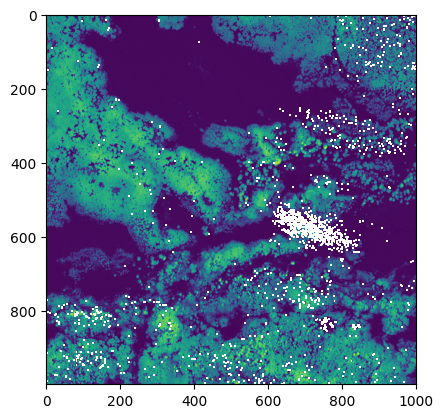

In [ ]:
from utils.HIZ import structures_per_zone



Notice the missing pixel values seen in the plot. I fill these in with a 3x3 moving window that fills in missing values with the average value of the 8 surrounding pixels.

This requires the raster to be saved as a nummp array, shown below.

In [74]:
# Saving as arrays is easy
arr_hmax = hmax.read(1)
arr_hmax

array([[  nan, 19.17, 18.89, ...,  9.99, 12.2 , 13.94],
       [  nan, 19.  , 19.09, ..., 13.78, 12.94, 16.83],
       [  nan, 19.98, 18.88, ..., 14.09, 14.42, 17.32],
       ...,
       [  nan, 22.18, 19.7 , ...,  3.03,  3.08,  2.66],
       [  nan, 22.54, 21.71, ...,  3.36,  3.54,  3.49],
       [  nan, 23.03, 22.56, ...,  4.07,  3.36,  3.22]], dtype=float32)

Creating a window required a few steps. First, defining what the window does. I call this function `fill_nan`. I use `generic_filter` from the `scipy` library, which does this automatically, providing three arguments: the **array** to filter, the **function** of the window, and the **size** of the window. Optionally, we can set **mode** based on how we want to treat pixels outside of the array. Let's stick with the default *reflect*. You can read more about options here: [https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.generic_filter.html]

In [75]:
from scipy.ndimage import generic_filter

# Define a function to compute the mean within a window
def fill_nan(window):
    valid_values = window[~np.isnan(window)]  # Exclude NaN values from calculation of mean
    if len(valid_values) > 0:
        return np.mean(valid_values)
    else:
        return 0  # If all values in the window are NaN, return 0

# Apply the moving window function to fill missing values
window_size = (3, 3)
arr_max = generic_filter(arr_hmax, fill_nan, size=window_size, mode='reflect')

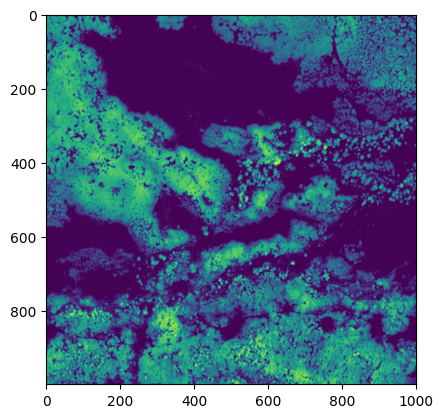

In [76]:
# Let's plot the new outputs to see the fruits of our toils
plt.imshow(arr_max)

Simply beautiful.

Now load in the shapefile `example_footprint.shp` and make sure the CRS aligns with the rasters. Then, we're going to create 3 home ignition zones around the building footprint according to NFPA standards, and look at the vegetation within it to get an idea of how much the vegetation around this home is contributing to its wildfire risk.

In [78]:
# Read in the shapefile
gdf = gpd.read_file("Data/example_footprint.shp") # gdf stands for GeoDataFrame
gdf

,FID,County,geometry
0,1439807,Gunnison County,"POLYGON ((-950222.010 1796808.097, -950219.690..."


We can see that there is only one object in this GeoDataFrame. It is a building footprint. Let's make a function that creates home ignition zones around the building footprint. Importantly, these zones should not overlap, since we want to perform analysis on the raster within each zone.

In [79]:
# Define a function `hiz` to create home ignition zone geometries from building footprints and specified distances
def get_hiz(footprints, z1 = 2, z2 = 10, z3 = 30):
   
    '''
    Enhances a GeoDataFrame of building footprints with additional columns for home ignition zones.
    
    NOTES: 
        - The unit of measurement will depend on your CRS (assumes CRS units in meters)
        - The zones do not overlap
    
    Parameters
    ------------------
    - footprints: GeoDataFrame with building footprints.
    - z1, z2, z3: Distances (m) for the respective zones around each footprint.
    
    Returns:
    ------------------
    - GeoDataFrame with original footprints and additional columns for each zone's buffer.
    
    '''

    # Define distances
    # Subtracts the previous zones so that total distance from home is the distance specified, but zones do not overlap
    dist_z1 = z1
    dist_z2 = z2 - z1
    dist_z3 = z3 - (z1 + z2)

    # Start with 'footprints' and buffer with '(distance = z1)'
    footprints['buffer_z1'] = footprints.buffer(distance = dist_z1).difference(footprints['geometry'])
    footprints['buffer_z2'] = footprints['geometry'].buffer(distance = dist_z2).difference(footprints['geometry'].buffer(dist_z1))
    footprints['buffer_z3'] = footprints['geometry'].buffer(distance = dist_z3).difference(footprints['geometry'].buffer(dist_z2))
    
    # Return enhanced GeoDataFrame
    return footprints

This function will work on a shapefile containing multiple footprints.

Now apply the function to the `gdf` object.

In [80]:
# Create a new geodataframe
hiz = get_hiz(gdf)
hiz

,FID,County,geometry,buffer_z1,buffer_z2,buffer_z3
0,1439807,Gunnison County,"POLYGON ((-950222.010 1796808.097, -950219.690...","POLYGON ((-950222.604 1796806.187, -950222.788...","POLYGON ((-950224.387 1796800.458, -950225.121...","POLYGON ((-950232.805 1796832.461, -950231.537..."


In order to save a shapefile of HIZs, each geometry column needs to be saved as a separate shapefile. Then we will load them back into the environment as individual files.

In [81]:
# Make sure each file contains one geometry column, and also 'FID' and "County'.
geom_cols = ['geometry', 'buffer_z1', 'buffer_z2', 'buffer_z3']
non_geom_cols = ['FID', 'County']

# Iterate and save each as a separate Shapefile
for geom_col in geom_cols:
    # Create a temporary GeoDataFrame with only the current geometry column and non-geometry columns
    temp_gdf = hiz[non_geom_cols + [geom_col]].copy()
    temp_gdf.set_geometry(geom_col, inplace=True)  # Loop through columns, setting each as the geometry column
    
    # Save to Shapefile
    temp_gdf.to_file(f'Data/hiz_{geom_col}.shp') # Edit filepath as needed to save to your working directory

Now we're going to define each shapefile as its own object and load all of them into our environment as GeoDataFrames.

In [82]:
z1 = gpd.read_file("Data/hiz_buffer_z1.shp")
z2 = gpd.read_file("Data/hiz_buffer_z2.shp")
z3 = gpd.read_file("Data/hiz_buffer_z3.shp")

We're going to clip our rasters to the extent of the given geometry for each of these.

Our simplified proxy for NFPA compliance is going to be the **average max height** of vegetation pixels within each zone.

The process of clipping rasters to geometries requires a fe steps. First, we're going to mask the max height raster `arr_max` with each HIZ geometry - `z1`, `z2`, and `z3`. To do this, we have to rasterize each geometry. The following 3 code blocks accomplish that, and save the masked raster outputs to arrays.

In [83]:
from rasterio.mask import mask
from rasterio.io import MemoryFile

# Prepare geometries from GeoDataFrame for masking
geoms = z1['geometry'].values # Zone 1

# Create a new in-memory dataset
with MemoryFile() as memfile:
    # Define metadata based on the properties of arr_max
    meta = {
        'driver': 'GTiff',
        'dtype': 'float32',
        'count': 1,
        'width': arr_max.shape[1],
        'height': arr_max.shape[0],
        'crs': hmax.crs,  # Update with the correct CRS as necessary
        'transform': hmax.transform,  # Update with the correct transform if available
        'nodata': np.nan
    }

    with memfile.open(**meta) as hmax_dataset:
        # Write arr_max to the in-memory dataset
        hmax_dataset.write(arr_max, 1)

        # Apply the mask using the geometries
        z1_out_values, z1_out_transform = mask(hmax_dataset, geoms, crop=True, nodata=np.nan)


In [84]:
geoms = z2['geometry'].values # Zone 2

# Create a new in-memory dataset
with MemoryFile() as memfile:
    # Define metadata based on the properties of arr_max
    meta = {
        'driver': 'GTiff',
        'dtype': 'float32',
        'count': 1,
        'width': arr_max.shape[1],
        'height': arr_max.shape[0],
        'crs': hmax.crs,  # Update with the correct CRS as necessary
        'transform': hmax.transform,  # Update with the correct transform if available
        'nodata': np.nan
    }

    with memfile.open(**meta) as hmax_dataset:
        # Write arr_max to the in-memory dataset
        hmax_dataset.write(arr_max, 1)

        # Apply the mask using the geometries
        z2_out_values, z2_out_transform = mask(hmax_dataset, geoms, crop=True, nodata=np.nan)


In [85]:
geoms = z3['geometry'].values # Zone 3

# Create a new in-memory dataset
with MemoryFile() as memfile:
    # Define metadata based on the properties of arr_max
    meta = {
        'driver': 'GTiff',
        'dtype': 'float32',
        'count': 1,
        'width': arr_max.shape[1],
        'height': arr_max.shape[0],
        'crs': hmax.crs,  # Update with the correct CRS as necessary
        'transform': hmax.transform,  # Update with the correct transform if available
        'nodata': np.nan
    }

    with memfile.open(**meta) as hmax_dataset:
        # Write arr_max to the in-memory dataset
        hmax_dataset.write(arr_max, 1)

        # Apply the mask using the geometries
        z3_out_values, z3_out_transform = mask(hmax_dataset, geoms, crop=True, nodata=np.nan)


Next, let's define a function for computing the average value of all the pixels.

We know that our zones are all donut-shaped. If we divide the sum of the pixels by the size of the array, then pixels both inside and outside the donut will be included in the size, and that will throw off our calculation. The above 3 code blocks have set all the values outside and inside of the donuts to `NaN`, so now we make sure our `calculate_avg` function divided by the number of *non-NaN* pixels in the array.

In [86]:
def calculate_avg(arr):
    
    # Count non-NaN values in the array
    non_nan_count = np.sum(~np.isnan(arr))
    # Compute the sum of non-NaN values
    non_nan_sum = np.sum(arr[~np.isnan(arr)])
    # Calculate the average (handle case when non_nan_count is 0 to avoid division by zero)
    avg = non_nan_sum / non_nan_count if non_nan_count > 0 else np.nan

    return avg

### RESULTS
All that's left to do is calculate the average max height per zone. Here are the results:

In [87]:
calculate_avg(z3_out_values)

2.3484971919686135

In [88]:
calculate_avg(z2_out_values)

3.054104777520576

In [89]:
calculate_avg(z1_out_values)

3.9157764165088382

### CONCLUSIONS

There are some insights and some caveats to draw from this from a fire mitigation perspective.

For a NFPA-compliant home ignition zone, we would expect to see taller average height values further away from the home. Instead, we are seeing the reverse.

The Z1 values have possibly been skewed by the home itself. Since the Microsoft building footprint does not perfectly align with the location of the building in the point cloud, it is likely that the building itself has been included in the max height calculation. A way to handle this would be to classify the point cloud to include buildings, and derive the building footprint directly from the LiDAR data.

The Z2 and Z3 values are probably more reliable. It tells us that there is tall vegetation surrounding the home. If the average height exceeds 3m in Z2, it is likely that this property could benefit from removing some trees and ensuring that the ground is clear of continuous flammable fuels. Since Z3 average max height is lower, it's likely that Z3 will not carry fire, although the average max height could be skewed by clumps of tall, continuous forest fuels interspersed with grassland, which is typical of this environment.

My conclusion is that average max height does not produce an actionable insight for home risk reduction. There is potential to develop better ways of producing actionable insights for home wildfire risk mitigation, but none have been developed (based on a meticulous review of over 150 papers and models). While the results presented here may prove to be a useful predictor in a random forest or multi-layer perceptron model, I will continue to test the value of different LiDAR metrics using the framework developed through this project.